# Training temperature prediction model

**Author: Miguel Ángel Ballester Granell**

Code inspired by Tensorflow tutorial https://www.tensorflow.org/tutorials/structured_data/time_series

This notebook contains the necessary code for training and evaluating the recurrent neural network for temperature forecast.

## Libraries

In [4]:
import os
import importlib

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import weather_forecast
importlib.reload(weather_forecast)

<module 'weather_forecast' from 'C:\\Users\\migue\\Documents\\Trabajos\\weather_prediction\\weather_forecast.py'>

## Data loading

In [ ]:
# Load data
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)

# Split
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train = df[0:int(n*0.7)]
val = df[int(n*0.7):int(n*0.9)]
test = df[int(n*0.9):]

## Preprocessing pipeline

In [ ]:
preprocess_pl = weather_forecast.WeatherPreprocessing()

train_df = preprocess_pl.fit_transform(data=train)

val_df = preprocess_pl.transform(data=val)

test_df = preprocess_pl.transform(data=test)

num_features = train_df.shape[1]

preprocess_pl.save_params('model/preprocess_params.csv')

In [2]:
train_df.head()

NameError: name 'train_df' is not defined

## Window generator

Total window size: 64
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Label indices: [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Label column name(s): ['T (degC)']

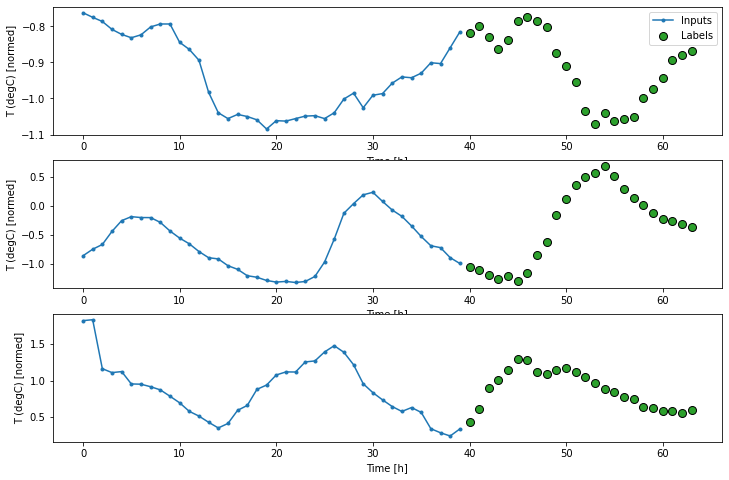

In [28]:
OUT_STEPS = 24
multi_window = weather_forecast.WindowGenerator(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    input_width=40,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    label_columns=['T (degC)']
)

multi_window.plot()
multi_window

## Define model

In [30]:
model = weather_forecast.WeatherModel(input_shape=(multi_window.input_width, len(multi_window.column_indices)), out_steps=OUT_STEPS)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40, 19)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 12)                1536      
_________________________________________________________________
dense (Dense)                (None, 24)                312       
_________________________________________________________________
reshape (Reshape)            (None, 24, 1)             0         
Total params: 1,848
Trainable params: 1,848
Non-trainable params: 0
_________________________________________________________________


## Training

In [31]:
model.compile_and_fit(multi_window, patience=4, max_epochs=30)

Epoch 1/30
 245/1532 [===>..........................] - ETA: 44s - loss: 0.6441 - mean_absolute_error: 0.6263

KeyboardInterrupt: 

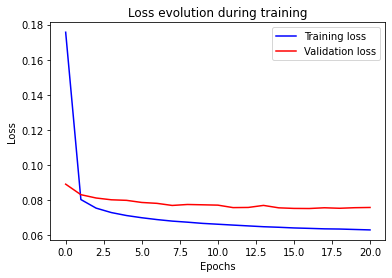

In [11]:
model.visualize_loss()

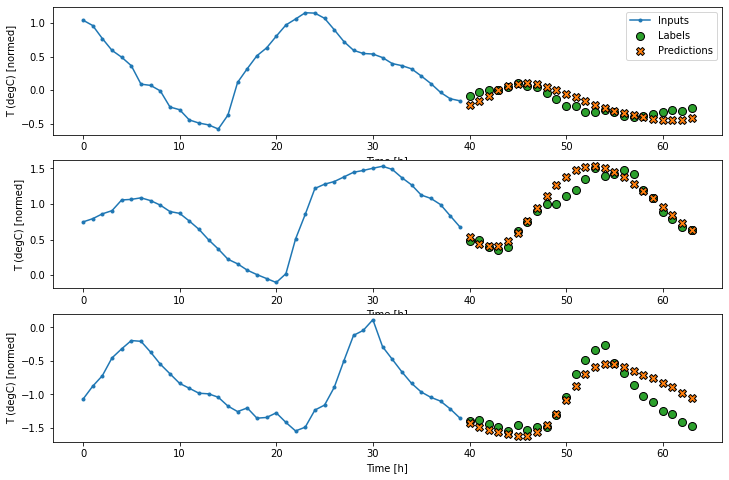

In [12]:
multi_window.plot(model)

## Error analysis

In [35]:
def visualize_model_error(true, pred, dataset):

    errors = y_true - y_pred

    print('Model results (' + dataset + ')')
    mean_sqr_error = np.mean(errors**2)

    print('Mean squared error: ' + str(round(mean_sqr_error, 4)))
    ss_res = np.sum(errors**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res/ss_tot

    print('R2: ' + str(round(r2, 4)))

    fig, axs = plt.subplots(1,1, figsize=(15,5))

    sns.violinplot(data=[errors[:,i,0] for i in range(errors.shape[1])], ax=axs)

    axs.set_title('Error distribution for each predicted timestep - ' + dataset)
    axs.set_xlabel('Timestep')

    plt.show()

### Training data

Model results (Training)
Mean squared error: 0.063
R2: 0.9369


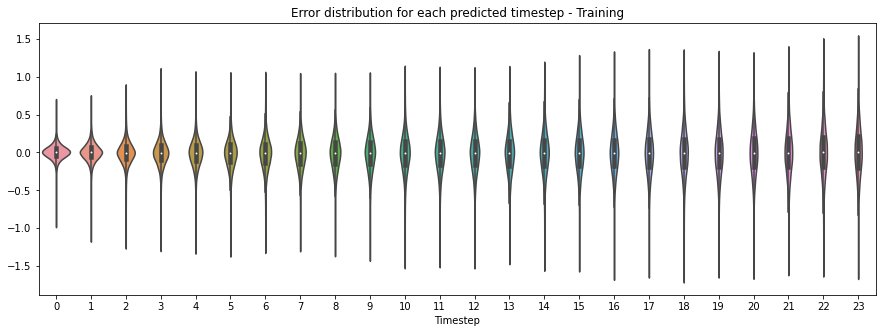

In [14]:
y_true = np.concatenate([y for x, y in multi_window.train_no_shuffle], axis=0)
y_pred = model.predict(multi_window.train_no_shuffle)

visualize_model_error(y_true, y_pred, 'Training')

### Validation data

Model results (Validation)
Mean squared error: 0.0759
R2: 0.9028


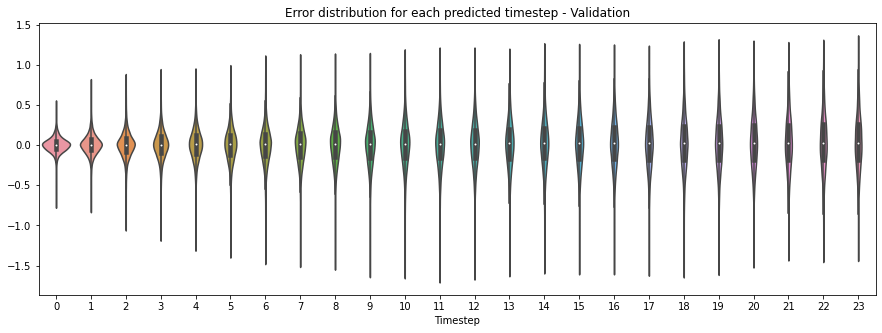

In [15]:
y_true = np.concatenate([y for x, y in multi_window.val], axis=0)
y_pred = model.predict(multi_window.val)

visualize_model_error(y_true, y_pred, 'Validation')

### Test data

Model results (Test)
Mean squared error: 0.0607
R2: 0.9254


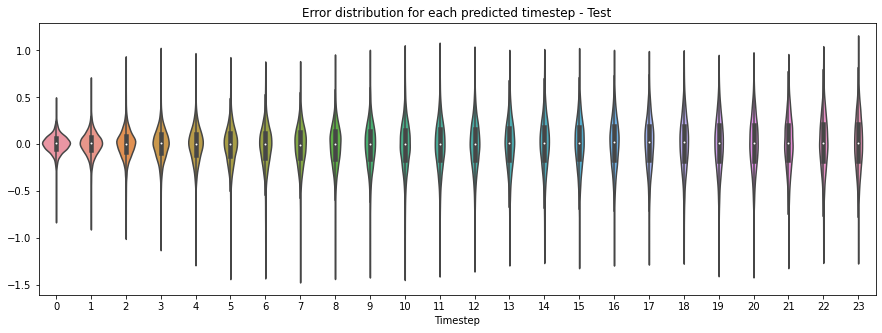

In [16]:
y_true = np.concatenate([y for x, y in multi_window.test], axis=0)
y_pred = model.predict(multi_window.test)

visualize_model_error(y_true, y_pred, 'Test')

## Save model

In [17]:
model.save_weights(filepath='model/weather_model.h5')

# model.load_weights(path='weather_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>